In [1]:
import os.path as osp

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import rand_score, silhouette_samples

from util import draw_silhouette, draw_wordcloud

In [2]:
temp_dir = osp.join('.', 'temp')
data = pd.read_csv(osp.join(temp_dir, 'data.csv'), encoding='utf-8')
features = pd.read_csv(osp.join(temp_dir, 'features.csv'), encoding='utf-8')

# Model training

In [3]:
random_state = 0
max_iter = 3000

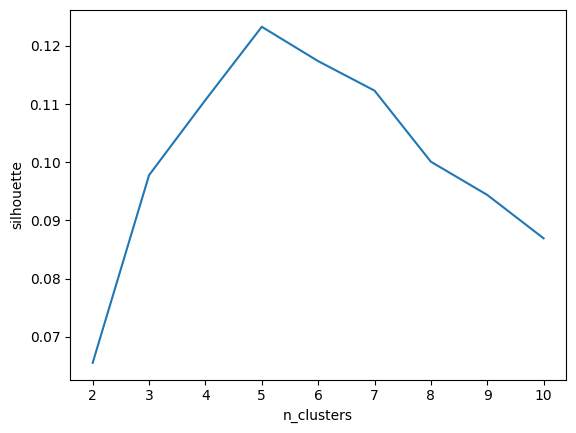

In [4]:
max_clusters = 10
scores = []

for i in range(2, max_clusters + 1):
    kmean = KMeans(n_clusters=i, random_state=random_state, max_iter=max_iter)
    score = silhouette_samples(features, kmean.fit_predict(features),
                               metric='cosine')
    scores.append(np.mean(score))

plt.plot(range(2, max_clusters + 1), [np.mean(i) for i in scores])
plt.xlabel('n_clusters')
plt.ylabel('silhouette')

kmean = KMeans(n_clusters=np.argmax(scores) + 2, random_state=random_state, max_iter=max_iter)
kmean_result = kmean.fit_predict(features)

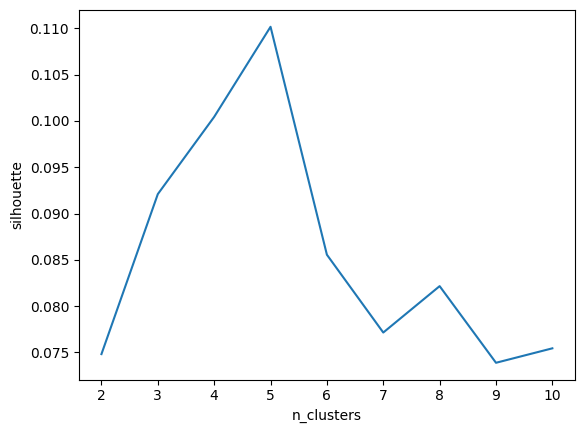

In [5]:
max_clusters = 10
scores = []

for i in range(2, max_clusters + 1):
    hac = AgglomerativeClustering(n_clusters=i)
    score = silhouette_samples(features, hac.fit_predict(features),
                               metric='cosine')
    scores.append(np.mean(score))

plt.plot(range(2, max_clusters + 1), [np.mean(i) for i in scores])
plt.xlabel('n_clusters')
plt.ylabel('silhouette')

hac = AgglomerativeClustering(n_clusters=np.argmax(scores) + 2)
hac_result = hac.fit_predict(features)

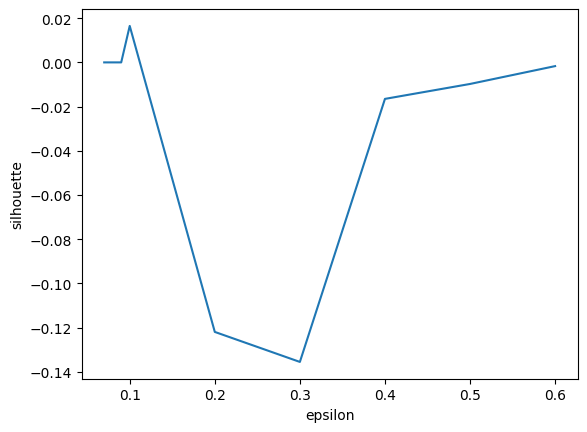

In [6]:
epses = [.07, .08, .09, .1, .2, .3, .4, .5, .6]
scores = []

for i in epses:
    dbs = DBSCAN(eps=i, metric='cosine', n_jobs=-1)
    temp = dbs.fit_predict(features)
    if np.unique(temp).shape[0] < 2:
        scores.append(0)
        continue
    score = silhouette_samples(features, temp, metric='cosine')
    scores.append(np.mean(score))

plt.plot(epses, scores)
plt.xlabel('epsilon')
plt.ylabel('silhouette')

dbs = DBSCAN(eps=epses[np.argmax(scores)], metric='cosine', n_jobs=-1)
dbs_result = dbs.fit_predict(features)

# Evaluate

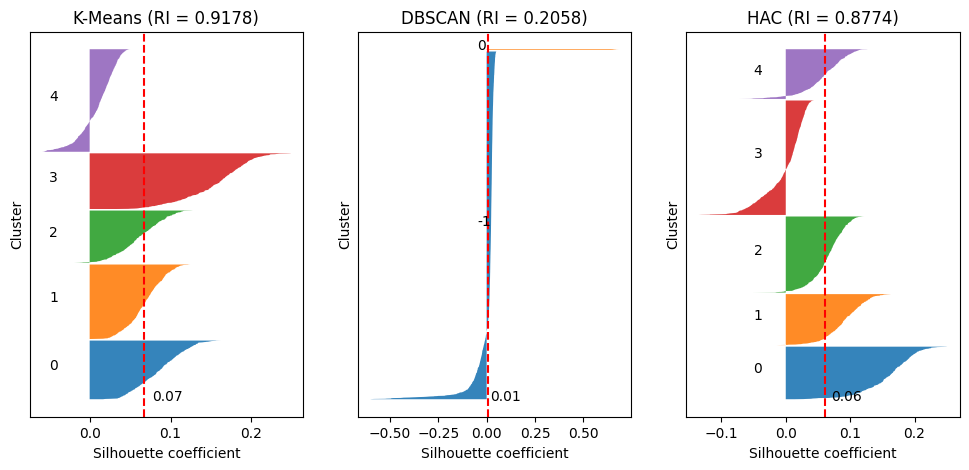

In [7]:
fig = plt.figure(figsize=(12, 5))

draw_silhouette(fig.add_subplot(1, 3, 1), features, kmean_result, 'K-Means')
draw_silhouette(fig.add_subplot(1, 3, 2), features, dbs_result, 'DBSCAN')
draw_silhouette(fig.add_subplot(1, 3, 3), features, hac_result, 'HAC')

fig.axes[0].set_title(fig.axes[0].get_title() + \
                      f" (RI = {rand_score(data['topic'], kmean_result):.4f})")
fig.axes[1].set_title(fig.axes[1].get_title() + \
                      f" (RI = {rand_score(data['topic'], dbs_result):.4f})")
fig.axes[2].set_title(fig.axes[2].get_title() + \
                      f" (RI = {rand_score(data['topic'], hac_result):.4f})")

pass

# Visualization

In [9]:
clustered = pd.concat([data, pd.DataFrame(kmean_result, columns=['cluster'])], axis=1)
clustered.groupby(['topic', 'cluster']).count()

article_index  link  article
topic     cluster                              
giao-duc  0                  409   409      409
          2                    1     1        1
          4                   31    31       31
khoa-hoc  0                    3     3        3
          1                    8     8        8
          4                  499   499      499
phap-luat 0                    1     1        1
          1                    3     3        3
          2                  366   366      366
          4                   25    25       25
suc-khoe  0                    1     1        1
          1                  514   514      514
          4                   32    32       32
the-thao  0                    1     1        1
          1                    2     2        2
          2                    4     4        4
          3                  394   394      394
          4                  138   138      138

<Axes: >

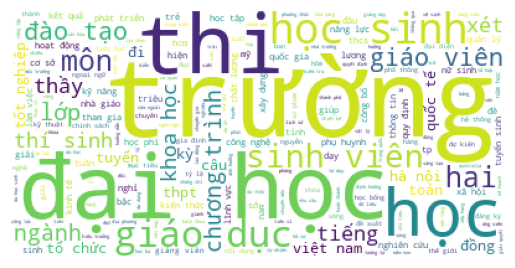

In [11]:
draw_wordcloud(clustered[clustered['cluster'] == 0]['article'], plt.gca(),
               background_color='white')

In [68]:
n = 10
print("Representative words:")
for i, cluster in enumerate(kmean.cluster_centers_):
    print(f"Cluster {i}:")
    print(' '*4 + ', '.join(features.columns[cluster.argpartition(-n)[-n:]].values))

Representative words:
Cluster 0:
    đào tạo, môn, giáo viên, sinh viên, học, giáo dục, đại học, học sinh, thi, trường
Cluster 1:
    đau, bệnh nhân, thuốc, máu, chất, người bệnh, viêm, điều trị, bệnh, bác sĩ
Cluster 2:
    tài sản, tỷ đồng, tỷ, vụ, điều tra, công an, án, đồng, cảnh sát, tiền
Cluster 3:
    sân, hai, thắng, bóng, hlv, bàn, cầu thủ, man, đội, trận
Cluster 4:
    độ, phát triển, bay, trái đất, biển, giải, công nghệ, chạy, khoa học, nghiên cứu


# Save

In [ ]:
import joblib
joblib.dump(osp.join('..', 'Output', 'kmean_model.pkl'))